# DATA WRANGLING PROGECT

### Goal 
#### : Using Python to get visualized reports analyzing data about twitter account @WeRateDogs for correlation and analysis for three different data sources.
#### 1- Rrchive File (CSV)
#### 2- Image Prediction
#### 3- Twitter API

In [11]:
#importing required libraries
import pandas as pd
import numpy as np
import requests
import os
import json
import tweepy
import configparser
import re
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
#from spicy import stats
%matplotlib inline

# DATA GATHERING

In [12]:
#reading data source 1..archive csv file
archive_df=pd.read_csv('twitter-archive-enhanced.csv')

In [13]:
#reading data source 2 programmatically..image prediction
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name=url.rsplit('/')[-1]
response = requests.get(url)
if not os.path.isfile(file_name):
    with open (file_name,'wb') as f:
        f.write (response.content)
image_predictions_df = pd.read_csv(file_name, sep='\t')
print('ok')

ok


In [5]:
#reading from twitter API 
tweets_ls = []
tweets_error_ls = []
tweet_ids_ls = archive_df['tweet_id']

consumer_key = '******************'
consumer_secret = '******************'
access_token = '******************'
access_secret = '******************'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
start=time.time()
if not os.path.isfile('tweet_json.txt'):
    for tweet_id in tweet_ids_ls:
        try:
            tweet = api.get_status(tweet_id, tweet_mode= 'extended')._json 
            favorites = tweet['favorite_count'] # number of favorites for the tweet
            retweets = tweet['retweet_count'] # number of retweets
            user_followers = tweet['user']['followers_count'] # number of followers of the user who tweeted
            user_favourites = tweet['user']['favourites_count'] # number of favourites for the user who tweeted
            date_time = tweet['created_at'] # the timestamp i.e. date and time of creation of the tweet
            tweets_ls.append({'tweet_id': int(tweet_id),
                            'favorites': int(favorites),
                            'retweets': int(retweets),
                            'user_followers': int(user_followers),
                            'user_favourites': int(user_favourites),
                            'date_time': pd.to_datetime(date_time)})
        except Exception as e:
            print(str(tweet_id)+ " _ " + str(e))
            tweets_error_ls.append(tweet_id)
    # total tweets received from api
    print("The lengh of the result", len(tweets_ls))

    # The tweet_id of the errors received from api
    print("The lengh of the errors", len(tweets_error_ls))
    
    # creating DataFrames
    tweets_json_df = pd.DataFrame(tweets_ls, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'user_favourites', 'date_time'])
    # saving the dataFrame to file
    tweets_json_df.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)
else:
    tweets_json_df = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
end=time.time()
print ('duration-----',end-start)
print('ok')

duration----- 0.007570743560791016
ok


# Data Assessing

Visual Assessment

In [9]:
tweets_json_df.to_csv('tweets_json_df.csv',index=False)

In [14]:
image_predictions_df.to_csv('image_predictions.csv',index=False)

Programatically assessment

In [15]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [17]:
archive_df.rating_denominator.value_counts().sort_index(ascending = True)

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [10]:
archive_df.rating_numerator.value_counts().sort_index(ascending = True)

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [18]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
tweets_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
tweet_id           2331 non-null int64
favorites          2331 non-null int64
retweets           2331 non-null int64
user_followers     2331 non-null int64
user_favourites    2331 non-null int64
date_time          2331 non-null object
dtypes: int64(5), object(1)
memory usage: 109.3+ KB


## issues
### Tideness
#### Table : All
#### Issue1 : Combine All  Data in one dataset
#### Table : Twitter_Archive 
#### Issue2 : Combine the data of 4 columns of dog stages into one column


### Quality
#### Table : Twitter_Archive
#### Issue4 : Removing retweet replies relevant columns
#### Table : Twitter_Archive
#### Issue5 : Removing denominators not equal 10
#### Table : Twitter_Archive
#### Issue6 : Removing numerators out of range 0-20
#### Table : Twitter_Archive
#### Issue7 : Transform Date_stamp to date time format
#### Table : Image_prediction
#### Issue8 : Removing image url
#### Table : Image_prediction
#### Issue9 : Keeping only P1 column for most probable breed
#### Table : Json_txt (Twitter API)
#### Issue10 : Merge with Archive and prediction data
#### Table : Json_txt (Twitter API)
#### Issue11 : Date time conversion
#### Issue12 : Removing 181 retweets
#### Table : Twitter_Archive
#### Issue13 : Removing 78 Replies

## Data Cleaning
### Twitter Archive

In [20]:
archive_df_clean = archive_df.copy()

In [21]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [2]:
## 1-	Removing 181 Re- tweets (Quality Issue):
## Using Drop function to eliminate the retweets as the required is only the original tweets


In [22]:
#removing 181 retweets

archive_df_clean.drop(archive_df_clean[archive_df_clean.retweeted_status_id.notnull()].index, inplace = True)

In [23]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

## 2-	Removing Replies to tweets (Quality Issue):
## Using Drop function to eliminate the replies to tweets as the required is only the original tweets


In [24]:
#removing 78 replies

archive_df_clean.drop(archive_df_clean[archive_df_clean.in_reply_to_user_id.notnull()].index, inplace = True)

In [25]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

## 3-	Removing Denominators not equal to 10 (Quality Issue):
##Using Drop function to eliminate the Denominators not equal to 10 as they are 17 records of 2097 records less than 0.8%


In [19]:
##Removing denominators not equal 10
archive_df_clean.drop(archive_df_clean[archive_df_clean.rating_denominator != 10].index, inplace = True)

In [20]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2080 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2080 non-null object
source                        2080 non-null object
text                          2080 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2077 non-null object
rating_numerator              2080 non-null int64
rating_denominator            2080 non-null int64
name                          2080 non-null object
doggo                         2080 non-null object
floofer                       2080 non-null object
pupper                        2080 non-null object
puppo                         2080 non-null object
dtypes: float64(4), int64(3), object(10)

## Removing nominator greater than 20 (Quality Issue):
## Using Drop function to eliminate the nominator greater than 20 as they are 5 records of 2080 records less than 0.2%

In [21]:
##Removing numerators out of range 0-20
archive_df_clean.drop(archive_df_clean[archive_df_clean.rating_numerator > 20].index, inplace = True)

In [22]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2075 non-null object
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2072 non-null object
rating_numerator              2075 non-null int64
rating_denominator            2075 non-null int64
name                          2075 non-null object
doggo                         2075 non-null object
floofer                       2075 non-null object
pupper                        2075 non-null object
puppo                         2075 non-null object
dtypes: float64(4), int64(3), object(10)

## 5-	Removing Irrelivant 5 colums related to retweets that were deleted earlier Using Drop function (Tidiness Issue)

In [23]:
## Removing retweet &replies relevant columns “in_reply_to_status_id - in_reply_to_user_id - retweeted_status_id  - retweeted_status_user_id - retweeted_status_timestamp “

irrelevant_col = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']


archive_df_clean.drop(irrelevant_col, inplace=True, axis=1)

In [24]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2075 non-null int64
timestamp             2075 non-null object
source                2075 non-null object
text                  2075 non-null object
expanded_urls         2072 non-null object
rating_numerator      2075 non-null int64
rating_denominator    2075 non-null int64
name                  2075 non-null object
doggo                 2075 non-null object
floofer               2075 non-null object
pupper                2075 non-null object
puppo                 2075 non-null object
dtypes: int64(3), object(9)
memory usage: 210.7+ KB


In [26]:
## creating new column named stage filled with dog stages doggo-floofer-pupper-puppo
#archive_df_clean.doggo.value_counts()
archive_df_clean.floofer.value_counts()
#archive_df_clean.pupper.value_counts()
#archive_df_clean.puppo.value_counts()


None       2087
floofer      10
Name: floofer, dtype: int64

In [27]:
# copying the dataframe to avoid errors in merging columns step
archive_df_clean2=archive_df_clean.copy()

In [28]:
archive_df_clean2.doggo = archive_df_clean2.doggo.replace(["None"], [""])

In [29]:
archive_df_clean2.floofer = archive_df_clean2.floofer.replace(["None"], [""])

In [30]:
archive_df_clean2.pupper = archive_df_clean2.pupper.replace(["None"], [""])

In [31]:
archive_df_clean2.puppo = archive_df_clean2.puppo.replace(["None"], [""])

In [34]:
archive_df_clean2.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,,,,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,,,,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,,,,


In [35]:
archive_df_clean2["dog_stage"]= archive_df_clean2["doggo"]+archive_df_clean2["floofer"]+archive_df_clean2["pupper"]+archive_df_clean2["puppo"]

In [36]:
archive_df_clean2["dog_stage"].value_counts()

                1761
pupper           221
doggo             72
puppo             23
floofer            9
doggopupper        9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [37]:
archive_df_clean2["dog_stage"]=archive_df_clean2["dog_stage"].replace("",np.nan)

In [38]:
archive_df_clean2["dog_stage"].value_counts()

pupper          221
doggo            72
puppo            23
floofer           9
doggopupper       9
doggopuppo        1
doggofloofer      1
Name: dog_stage, dtype: int64

In [39]:
archive_df_clean2.loc[archive_df_clean2.dog_stage == 'doggopupper', 'dog_stage'] = 'multiple'

In [40]:
archive_df_clean2.loc[archive_df_clean2.dog_stage == 'doggopuppo', 'dog_stage'] = 'multiple'

In [41]:
archive_df_clean2.loc[archive_df_clean2.dog_stage == 'doggofloofer', 'dog_stage'] = 'multiple'

In [42]:
archive_df_clean2["dog_stage"].value_counts()

pupper      221
doggo        72
puppo        23
multiple     11
floofer       9
Name: dog_stage, dtype: int64

In [43]:
archive_df_clean=archive_df_clean2.copy()

In [44]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dog_stage                     336 non-nu

In [45]:
# removing columns after merging the stages

unwanted_col = ['doggo','floofer','pupper','puppo']


archive_df_clean.drop(unwanted_col, inplace=True, axis=1)

In [46]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
dog_stage                     336 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 245.7+ KB


In [49]:
# converting timestamp to date time format
archive_df_clean['timestamp'] = pd.to_datetime(archive_df_clean.timestamp)

In [50]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
dog_stage                     336 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(6)
memory usage: 245.7+ KB


## Image Prediction dataframe

In [51]:
#creating copy of image prediction

pred_df_clean=image_predictions_df.copy()

In [52]:
# Renaming the dataframe columns names
new_col_names = {'p1':'dog_breed_prediction', 'p1_conf':'prediction_confidence'}

pred_df_clean.rename(columns= new_col_names, inplace=True)

In [53]:
pred_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                 2075 non-null int64
jpg_url                  2075 non-null object
img_num                  2075 non-null int64
dog_breed_prediction     2075 non-null object
prediction_confidence    2075 non-null float64
p1_dog                   2075 non-null bool
p2                       2075 non-null object
p2_conf                  2075 non-null float64
p2_dog                   2075 non-null bool
p3                       2075 non-null object
p3_conf                  2075 non-null float64
p3_dog                   2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [54]:
## Dropping false predictions that doesnt belong to dogs images
pred_df_clean.drop(pred_df_clean[pred_df_clean.p1_dog == False].index, inplace=True)

In [55]:
pred_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id                 1532 non-null int64
jpg_url                  1532 non-null object
img_num                  1532 non-null int64
dog_breed_prediction     1532 non-null object
prediction_confidence    1532 non-null float64
p1_dog                   1532 non-null bool
p2                       1532 non-null object
p2_conf                  1532 non-null float64
p2_dog                   1532 non-null bool
p3                       1532 non-null object
p3_conf                  1532 non-null float64
p3_dog                   1532 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 124.2+ KB


In [56]:
## deleting the unwanted columns 'jpg_url', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p2_conf', 'p3_dog', 'p3_conf'
pred_unwanted_cols = ['jpg_url', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p2_conf', 'p3_dog', 'p3_conf']

pred_df_clean.drop(pred_unwanted_cols, inplace=True, axis=1)

In [57]:
pred_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 2073
Data columns (total 4 columns):
tweet_id                 1532 non-null int64
img_num                  1532 non-null int64
dog_breed_prediction     1532 non-null object
prediction_confidence    1532 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 59.8+ KB


## Twitter API Extra Data

In [58]:
#copying twitter API txt_json file
api_df_clean=tweets_json_df.copy()

In [59]:
api_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
tweet_id           2331 non-null int64
favorites          2331 non-null int64
retweets           2331 non-null int64
user_followers     2331 non-null int64
user_favourites    2331 non-null int64
date_time          2331 non-null object
dtypes: int64(5), object(1)
memory usage: 109.3+ KB


In [60]:
api_df_clean.drop('date_time',axis='columns', inplace=True)

In [61]:
api_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
tweet_id           2331 non-null int64
favorites          2331 non-null int64
retweets           2331 non-null int64
user_followers     2331 non-null int64
user_favourites    2331 non-null int64
dtypes: int64(5)
memory usage: 91.1 KB


## Creating Master datafile

In [62]:
# merging all cleaned files into master dataframe considering tha main sourse is image predictions
master_df_1st = pd.merge(pred_df_clean,archive_df_clean, on='tweet_id', how='left')

In [63]:
# merging all cleaned files into master dataframe
master_df = pd.merge(master_df_1st, api_df_clean, on='tweet_id', how='left')

## Exporting clean files to csv

In [64]:
## Exporting All cleaned files and master dataframe to csv files
archive_df_clean.to_csv('archive_clean.csv',index=False)

In [65]:
## Exporting All cleaned files and master dataframe to csv files
pred_df_clean.to_csv('image_prediction_clean.csv',index=False)

In [66]:
## Exporting All cleaned files and master dataframe to csv files
api_df_clean.to_csv('twitter_api_clean.csv',index=False)

In [67]:
## Exporting All cleaned files and master dataframe to csv files
master_df.to_csv('twitter_archive_master.csv',index=False)

# Insights and Visualization

In [68]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 1531
Data columns (total 21 columns):
tweet_id                      1532 non-null int64
img_num                       1532 non-null int64
dog_breed_prediction          1532 non-null object
prediction_confidence         1532 non-null float64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1463 non-null datetime64[ns]
source                        1463 non-null object
text                          1463 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1463 non-null object
rating_numerator              1463 non-null float64
rating_denominator            1463 non-null float64
name                          1463 non-null object
dog_stage                     227 non-null object
favorites                    

In [69]:
master_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1437
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       19
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       7
Name: source, dtype: int64

In [70]:
master_df = master_df.replace(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'],'Twitter for iPhone')

In [71]:
master_df = master_df.replace(['<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'],'Twitter Web Client')

In [72]:
master_df = master_df.replace(['<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],'TweetDeck')

In [73]:
master_df.source.value_counts()

Twitter for iPhone    1437
Twitter Web Client      19
TweetDeck                7
Name: source, dtype: int64

In [74]:
source=['Twitter for iPhone','Twitter Web Client','TweetDeck']
source_counts= [1420,19,7]

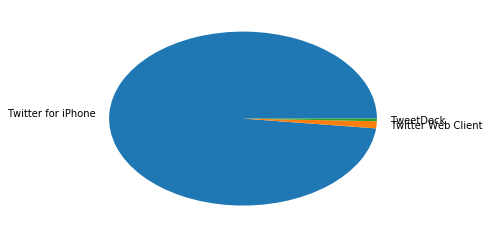

In [75]:
plt.pie(source_counts, labels = source) 
plt.show()

In [76]:
master_df.rating_numerator.value_counts()

12.0     378
10.0     318
11.0     305
13.0     208
9.0      107
8.0       58
7.0       24
14.0      19
6.0       12
5.0       10
4.0        5
3.0        3
88.0       1
1.0        1
75.0       1
99.0       1
26.0       1
44.0       1
60.0       1
45.0       1
80.0       1
50.0       1
27.0       1
24.0       1
84.0       1
165.0      1
121.0      1
2.0        1
Name: rating_numerator, dtype: int64

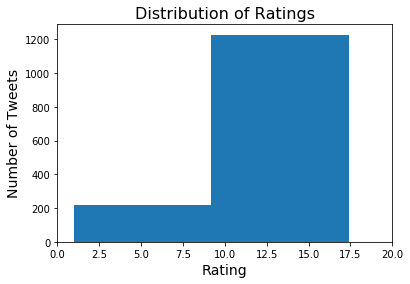

In [77]:
master_df['rating_numerator'].plot(kind = 'hist', bins = 20)

plt.xlim(0, 20)
plt.ylabel('Number of Tweets', fontsize = 14)
plt.xlabel('Rating', fontsize = 14)
plt.title('Distribution of Ratings', fontsize = 16)
plt.show()

In [78]:
master_df.dog_stage.value_counts()

pupper      144
doggo        48
puppo        19
multiple      9
floofer       7
Name: dog_stage, dtype: int64

In [79]:
stage=['pupper','doggo','puppo','multiple','floofer']
stage_counts= [143,48,19,9,7]

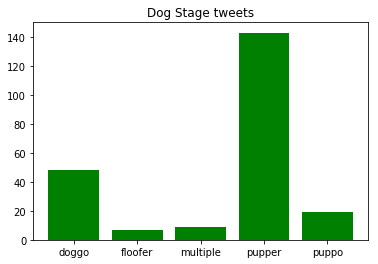

In [80]:
plt.bar(stage, stage_counts, color='green')
plt.title('Dog Stage tweets')
plt.show()

In [81]:
master_df.dog_breed_prediction.value_counts()

golden_retriever               150
Labrador_retriever             100
Pembroke                        89
Chihuahua                       83
pug                             57
chow                            44
Samoyed                         43
toy_poodle                      39
Pomeranian                      38
malamute                        30
cocker_spaniel                  30
French_bulldog                  26
Chesapeake_Bay_retriever        23
miniature_pinscher              23
German_shepherd                 20
Staffordshire_bullterrier       20
Siberian_husky                  20
Cardigan                        19
Shetland_sheepdog               18
Maltese_dog                     18
beagle                          18
Eskimo_dog                      18
Shih-Tzu                        17
Lakeland_terrier                17
Rottweiler                      17
kuvasz                          16
Italian_greyhound               16
West_Highland_white_terrier     14
Great_Pyrenees      

In [82]:
breed=['golden_retriever','Labrador_retriever','Pembroke','Chihuahua','pug','chow','Samoyed','toy_poodle','Pomeranian','malamute']
breed_counts= [150,100,89,83,57,44,43,39,38,30]

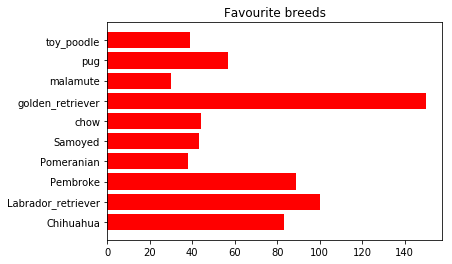

In [83]:
plt.barh(breed, breed_counts, color='red')
plt.title('Favourite breeds')
plt.show()

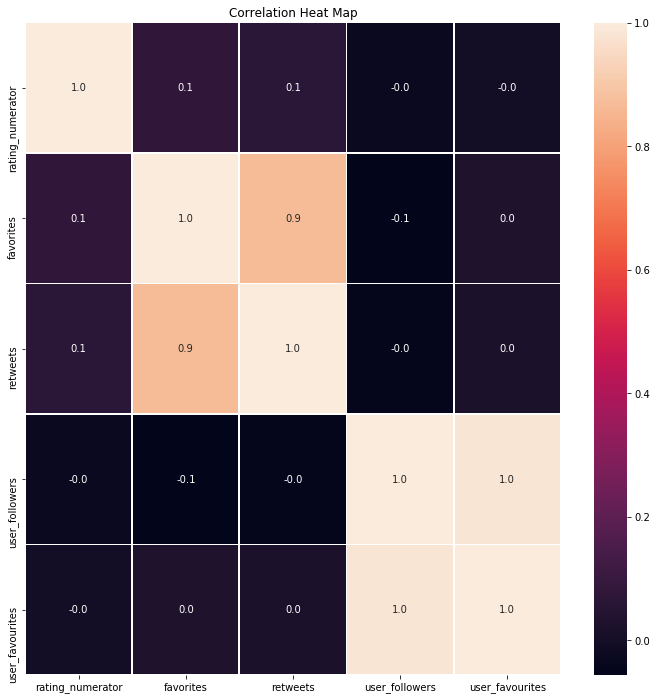

In [84]:
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(master_df[['dog_breed_prediction','rating_numerator','favorites','retweets',
               'dog_stage','user_followers','user_favourites']].corr(), annot=True, linewidths=.8, fmt= '.1f',ax=ax)
plt.title('Correlation Heat Map')
plt.savefig('corr.png')